# CNN Histopathologic Cancer Detection

The challenge goal is to create a model that can be provided images with a center pixel size of 32x32 and determine if a piece of the image looks like it contains a tumor. This will be a binary classifier to determine if the image contains a tumor or not.

Dataset Citation:
Will Cukierski. Histopathologic Cancer Detection. https://kaggle.com/competitions/histopathologic-cancer-detection, 2018. Kaggle.

In [13]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Flatten, Dense, Input, Dropout
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalseNegatives

from pathlib import Path

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Exploratory Data Analysis (EDA)

From the dataset description I know that the images have been de-dupped for this project because the original dataset does contain duplicates. Also the data is padded, but only the center 32x32 segment should be used for the decision, for now we will not be removing the padding.

Looking for any invalid entries or any invalid labels first and visually inspect some samples.

                                          label
id                                             
d43c081bafa286f9c1f7e921883f26ceafebc912      1
Image Size (96, 96)


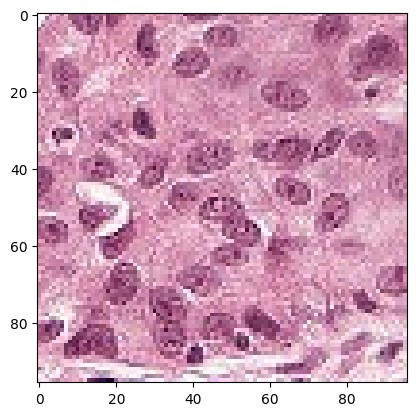

                                          label
id                                             
092d0eedebce504847715ee046b6ad74b57599b4      0
Image Size (96, 96)


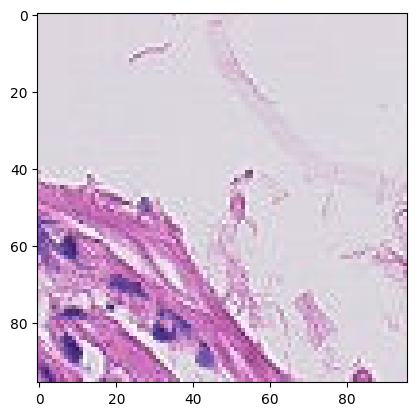

                                          label
id                                             
b0d2582c6218a8764323fc940b41312282b99bf4      0
Image Size (96, 96)


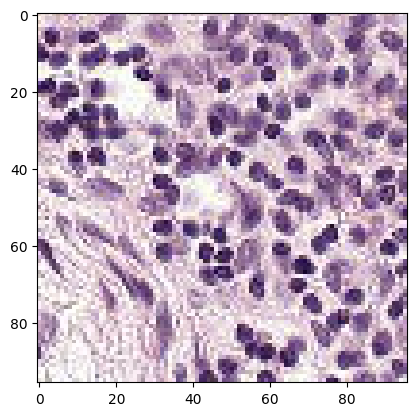

Missing train label count: 0
Invalid ID count: 0
Label 0: 130908
Label 1: 89117


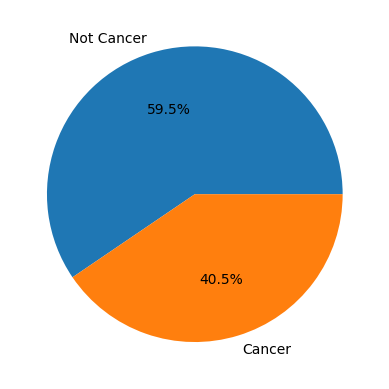

In [6]:
sample_submission_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
train_labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

# Directory containing .tif files to train the model on
train_directory = Path("/kaggle/input/histopathologic-cancer-detection/train")
# Directory containg .tif files for the test submission
test_directory = Path("/kaggle/input/histopathologic-cancer-detection/test")

# Change index 
train_labels_df.set_index("id", inplace=True)

three_train_samples = list(train_directory.iterdir())[:3]

# Show three samples
for train_sample in three_train_samples:
    img = Image.open(train_sample)
    print(train_labels_df[train_labels_df.index == train_sample.with_suffix("").name])
    print("Image Size", img.size)
    plt.imshow(img)
    plt.show()


train_label_ids = train_labels_df.index
file_ids = set()

# Look for any mismatch records
for sample in train_directory.iterdir():
    file_ids.add(sample.with_suffix("").name)
print("Missing train label count:", len(np.setdiff1d(sorted(file_ids), sorted(train_label_ids))))

# Look for any invalid labels
print("Invalid ID count:", len(train_labels_df[~train_labels_df.label.isin((0, 1))]))

# Distribution of found or not found cancer
count_label_0 = len(train_labels_df[train_labels_df.label == 0])
count_label_1 = len(train_labels_df[train_labels_df.label == 1])
print("Label 0:", count_label_0)
print("Label 1:", count_label_1)

plt.pie([count_label_0, count_label_1], labels=["Not Cancer", "Cancer"], autopct="%1.1f%%")
plt.show()

The total image size is 96x96 and we can see some samples that are flagged as having a cancer flag ("label") of 1. Also all the training labels matched up from the csv and the labels are only 0 and 1.

## Architecture

Planning to use a CNN leveraging Keras to create a few different models. 


In [7]:
# Special function to load .tif since Keras doesn't have built in support
def load_image(path: Path):
    with Image.open(path) as img:
        return img_to_array(img)

# Working with all of the data is not feasible on the current hardware, so scale back sample size
input_files = np.random.choice(sorted(train_directory.iterdir()), size=10000)
train_length = len(input_files)

input_ids = [image.with_suffix("").name for image in input_files]

def data_generator():
    for image in tqdm(input_files):
        yield load_image(image)

train_image_data = np.fromiter(data_generator(), dtype=np.dtype((np.int8, (96, 96, 3))), count=train_length)
print("Loaded image data")
train_image_label = np.array(train_labels_df.loc[input_ids].label)
print("Loaded image labels")

100%|█████████▉| 9999/10000 [01:11<00:00, 139.38it/s]

Loaded image data
Loaded image labels


In [8]:
print(tf.config.list_physical_devices(device_type=None))


# Simple Keras Model
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(96, 3, activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)

with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_image_data,
        y=train_image_label,
        batch_size=None,
        epochs=20,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 92, 92, 32)     │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        28,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,017 (445.38 KB)

 Trainable params: 114,017 (445.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - binary_accuracy: 0.6221 - false_negatives_1: 698.2789 - loss: 1.3409 - val_binary_accuracy: 0.7045 - val_false_negatives_1: 281.0000 - val_loss: 0.6469
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - binary_accuracy: 0.7601 - false_negatives_1: 518.6614 - loss: 0.5436 - val_binary_accuracy: 0.7505 - val_false_negatives_1: 197.0000 - val_loss: 0.5767
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - binary_accuracy: 0.8303 - false_negatives_1: 389.8366 - loss: 0.4055 - val_binary_accuracy: 0.7530 - val_false_negatives_1: 282.0000 - val_loss: 0.5383
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - binary_accuracy: 0.8736 - false_negatives_1: 295.9283 - loss: 0.3019 - val_binary_accuracy: 0.7650 - val_false_negatives_1: 265.0000 - val_loss: 0.5474
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - binary_accuracy: 0.9234 - false_negatives_1: 180.9243 - loss: 0.2198 - val_binary_accuracy: 0.7105 - val_false_n

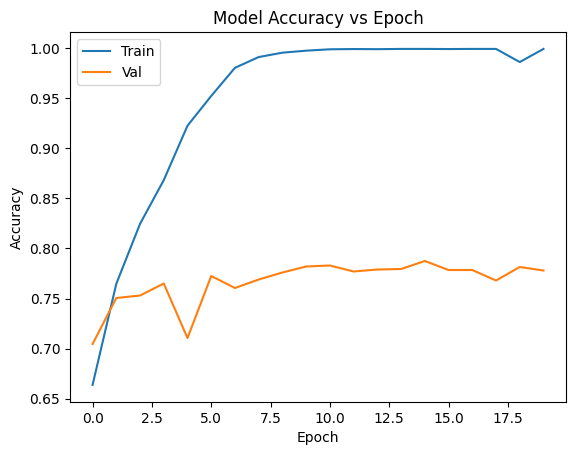

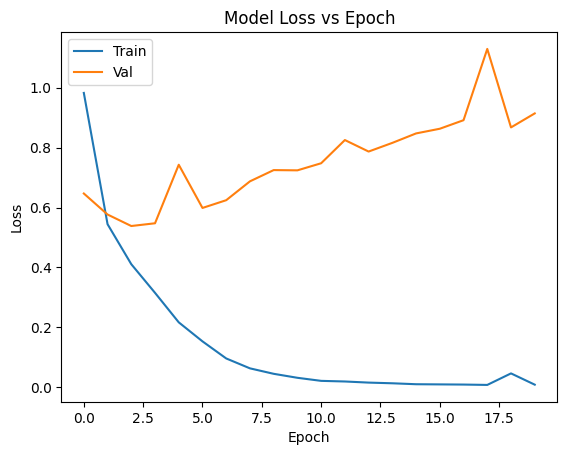

In [10]:
# Graphs for the previous model fit
# Accuracy
plt.plot(model_fit.history["binary_accuracy"])
plt.plot(model_fit.history["val_binary_accuracy"])
plt.title("Model Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Loss
plt.plot(model_fit.history["loss"])
plt.plot(model_fit.history["val_loss"])
plt.title("Model Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()


It looks like there was some over fitting so trying a dropout layer.

In [14]:
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(96, 3, activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2),
    Dropout(0.10),
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)

with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_image_data,
        y=train_image_label,
        batch_size=None,
        epochs=20,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 92, 92, 32)     │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        28,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,017 (445.38 KB)

 Trainable params: 114,017 (445.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - binary_accuracy: 0.6294 - false_negatives_2: 673.6295 - loss: 1.5701 - val_binary_accuracy: 0.7040 - val_false_negatives_2: 268.0000 - val_loss: 0.6450
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.7303 - false_negatives_2: 568.2789 - loss: 0.6232 - val_binary_accuracy: 0.7445 - val_false_negatives_2: 199.0000 - val_loss: 0.5523
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.7786 - false_negatives_2: 501.0120 - loss: 0.4874 - val_binary_accuracy: 0.7415 - val_false_negatives_2: 161.0000 - val_loss: 0.5265
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.8086 - false_negatives_2: 448.0478 - loss: 0.4368 - val_binary_accuracy: 0.7805 - val_false_negatives_2: 248.0000 - val_loss: 0.4758
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.8288 - false_negatives_2: 406.4861 - loss: 0.3882 - val_binary_accuracy: 0.7505 - val_false_n

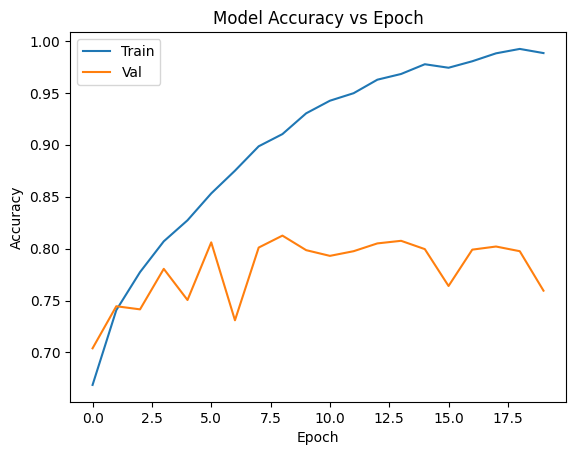

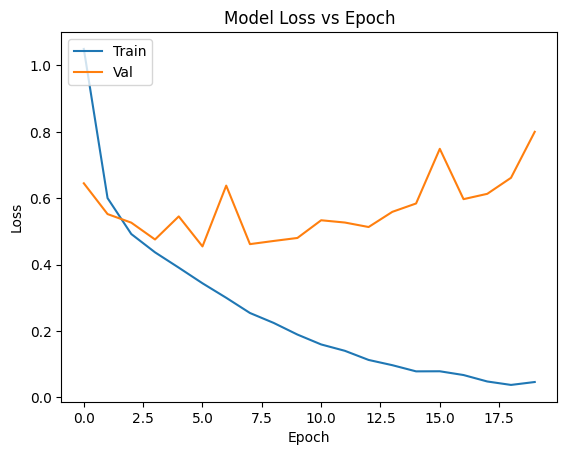

In [15]:
# Graphs for the previous model fit
# Accuracy
plt.plot(model_fit.history["binary_accuracy"])
plt.plot(model_fit.history["val_binary_accuracy"])
plt.title("Model Accuracy vs Epoch")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()

# Loss
plt.plot(model_fit.history["loss"])
plt.plot(model_fit.history["val_loss"])
plt.title("Model Loss vs Epoch")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Val"], loc="upper left")
plt.show()


## Results and Analysis

Trying with the Dropout layer and without, as well as looking at the different epochs it appears that at epoch five the model performance the best. Using the best model below with epoch of five.

In [16]:
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(96, 3, activation='relu'),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2),
    Dropout(0.10),
    Conv2D(64, 3, activation='relu'),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2),
    Flatten(),
    Dense(1, activation='sigmoid')
])

print(model.summary())

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=BinaryCrossentropy(),
    metrics=[
        BinaryAccuracy(),
        FalseNegatives(),
    ],
)

with tf.device("/device:GPU:0"):
    model_fit = model.fit(
        x=train_image_data,
        y=train_image_label,
        batch_size=None,
        epochs=5,
        verbose="auto",
        validation_split=0.2,
        shuffle=True,
        class_weight=None,
        sample_weight=None,
        initial_epoch=0,
        steps_per_epoch=None,
        validation_steps=None,
        validation_batch_size=None,
        validation_freq=1,
    )



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 94, 94, 96)     │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 92, 92, 32)     │        27,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 44, 44, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 28224)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │        28,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,017 (445.38 KB)

 Trainable params: 114,017 (445.38 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - binary_accuracy: 0.6100 - false_negatives_3: 706.2908 - loss: 1.5970 - val_binary_accuracy: 0.7020 - val_false_negatives_3: 161.0000 - val_loss: 0.6983
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.7299 - false_negatives_3: 554.4542 - loss: 0.6289 - val_binary_accuracy: 0.7620 - val_false_negatives_3: 267.0000 - val_loss: 0.5472
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.7933 - false_negatives_3: 459.8566 - loss: 0.4618 - val_binary_accuracy: 0.7395 - val_false_negatives_3: 111.0000 - val_loss: 0.5886
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.8219 - false_negatives_3: 406.4861 - loss: 0.4088 - val_binary_accuracy: 0.7820 - val_false_negatives_3: 194.0000 - val_loss: 0.4914
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.8534 - false_negatives_3: 358.8247 - loss: 0.3409 - val_binary_accuracy: 0.7935 - val_false_negati

In [51]:
# Running through the test
submission_file = Path("submission.csv")

test_files = list(test_directory.iterdir())
test_files_count = len(test_files)

def load_image(path: Path):
    with Image.open(path) as img:
        return img_to_array(img)

def data_generator():
    for image in tqdm(test_files):
        yield load_image(image)

test_image_data = np.fromiter(data_generator(), dtype=np.dtype((np.int8, (96, 96, 3))), count=test_files_count)
predictions = model.predict(test_image_data)

# Delete exsiting submission file
submission_file.unlink(missing_ok=True)
with submission_file.open("a") as f:
    f.write("id,label\n")
    for test_file, prediction in zip(test_files, predictions):
        f.write(f"{test_file.with_suffix('').name},{prediction[0]}\n")

#print(submission_file.read_text())

100%|█████████▉| 57457/57458 [08:34<00:00, 111.63it/s]


1796/1796 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step


## Conclusion 

It would have been nice to have a system performant enough to train on the entire dataset but to keep things reasonable a random sampling of 10000 inputs had to be used and then for validation 20% of that was used. It is amazing that will relative ease a model with better than 50% accuracy can be created. The dropout layer also did not have the complete expected behavior. In conclusion the models ended up performing as well as they could given that not all of the training data could be used to create the model with the limited memory of the running system. 